In [21]:
import math
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
from matplotlib import pyplot as plt
from scipy.stats import kstest
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [22]:
def convert_to_float(value):        
    if "K" in value:
        return float(value[:-1]) * 1000
    if "M" in value:
        return float(value[:-1]) * 1000000
    if "B" in value:
        return float(value[:-1]) * 1000000000
    if "%" in value:
        return float(value[:-1]) / 100
    if value == "-":
        return None
    return float(value.replace(",", ""))

In [23]:
def test_normality(data):
    stat, p = kstest(data, "norm")
    print("stat = ", stat)
    print("p = ", p)
    if p > 0.05:
        print("Probably Gaussian.")
    else:
        print("Not Gausssian.")

In [24]:
def prepare_for_lstm(data, look_back):
    data_x, data_y = [], []
    for i in range(len(data) - look_back):
        data_window = data[i:i + look_back]
        data_x.append(data_window)
        data_y.append(data[i + look_back])
    return np.array(data_x), np.array(data_y)

In [25]:
ether_data = pd.read_csv("Datasets/ETH-USD-Data.csv")
ether_data.rename(columns={"Price": "Close", "Vol.": "Volume", "Change %": "Change"}, inplace=True)
ether_data["Date"] = ether_data['Date'].astype("datetime64")
for column in ether_data.columns[1:]:
    ether_data[column] = ether_data[column].apply(convert_to_float)
ether_data = ether_data.reindex(columns=["Date", "Open", "High", "Low", "Close", "Volume", "Change"]).set_index("Date").sort_values("Date")
ether_data = ether_data.interpolate()

In [26]:
ether_data

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2016-03-10,11.20,11.85,11.07,11.75,0.0,0.0491
2016-03-11,11.75,11.95,11.75,11.95,180.0,0.0170
2016-03-12,11.95,13.45,11.95,12.92,830.0,0.0812
2016-03-13,12.92,15.07,12.92,15.07,1300.0,0.1664
2016-03-14,15.07,15.07,11.40,12.50,92180.0,-0.1705
...,...,...,...,...,...,...
2022-05-05,2940.70,2952.84,2730.95,2747.46,899820.0,-0.0657
2022-05-06,2747.60,2757.14,2635.85,2692.88,881180.0,-0.0199
2022-05-07,2692.92,2703.11,2589.29,2636.03,458050.0,-0.0211


In [27]:
ether_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2252 entries, 2016-03-10 to 2022-05-09
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2252 non-null   float64
 1   High    2252 non-null   float64
 2   Low     2252 non-null   float64
 3   Close   2252 non-null   float64
 4   Volume  2252 non-null   float64
 5   Change  2252 non-null   float64
dtypes: float64(6)
memory usage: 123.2 KB


In [28]:
ether_data.describe()

,Open,High,Low,Close,Volume,Change
count,2252.000000,2252.000000,2252.000000,2252.000000,2.252000e+03,2252.000000
mean,812.901239,841.363615,780.354378,813.961607,1.323084e+07,0.003973
std,1163.234596,1199.773415,1120.483259,1163.604697,1.037117e+08,0.056057
min,6.680000,7.320000,5.860000,6.700000,0.000000e+00,-0.445500
25%,135.372500,139.487500,130.700000,135.460000,5.336425e+05,-0.022300
50%,258.000000,268.905000,242.690000,258.900000,1.480000e+06,0.001100
75%,754.400000,798.180000,719.557500,759.147500,7.942500e+06,0.029425
max,4808.340000,4864.060000,4715.430000,4808.380000,1.790000e+09,0.295100


In [29]:
ether_data.corr()

,Open,High,Low,Close,Volume,Change
Open,1.000000,0.999374,0.998569,0.998238,0.104588,-0.032946
High,0.999374,1.000000,0.998477,0.999155,0.104855,-0.017002
Low,0.998569,0.998477,1.000000,0.999118,0.106389,-0.012295
Close,0.998238,0.999155,0.999118,1.000000,0.105243,0.000184
Volume,0.104588,0.104855,0.106389,0.105243,1.000000,0.000230
Change,-0.032946,-0.017002,-0.012295,0.000184,0.000230,1.000000


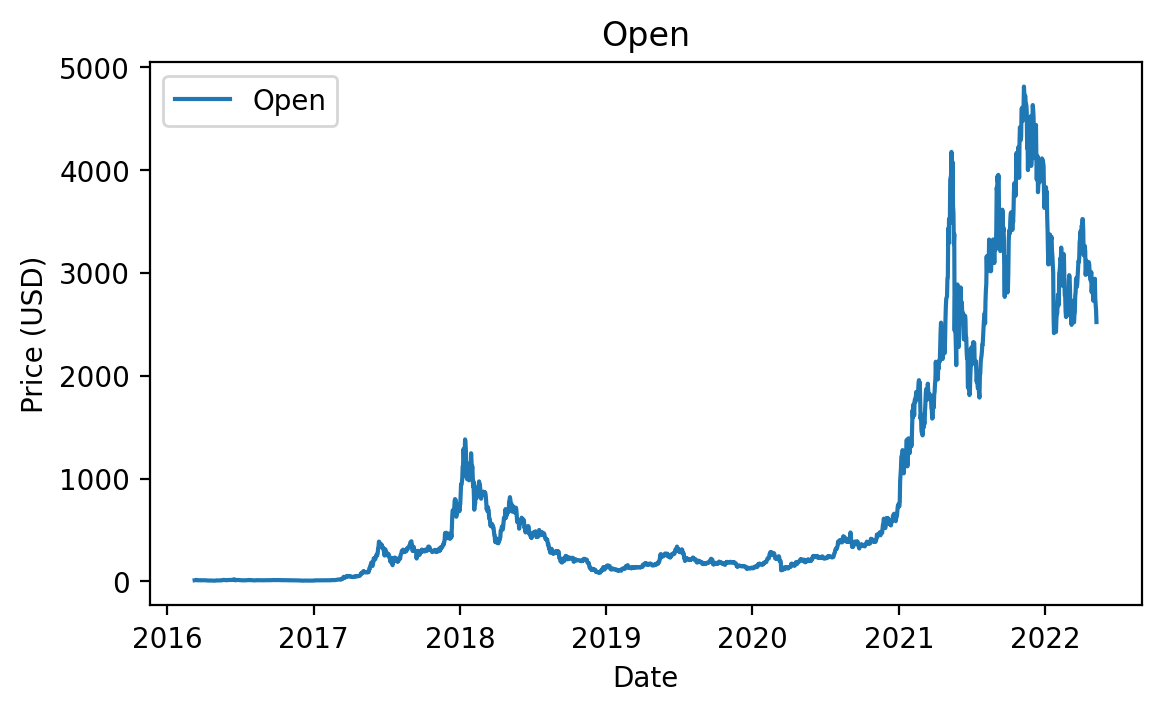

In [30]:
plt.figure(figsize=(6.40, 3.60), dpi=200)
plt.plot(ether_data["Open"], label="Open")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Open")
plt.show()

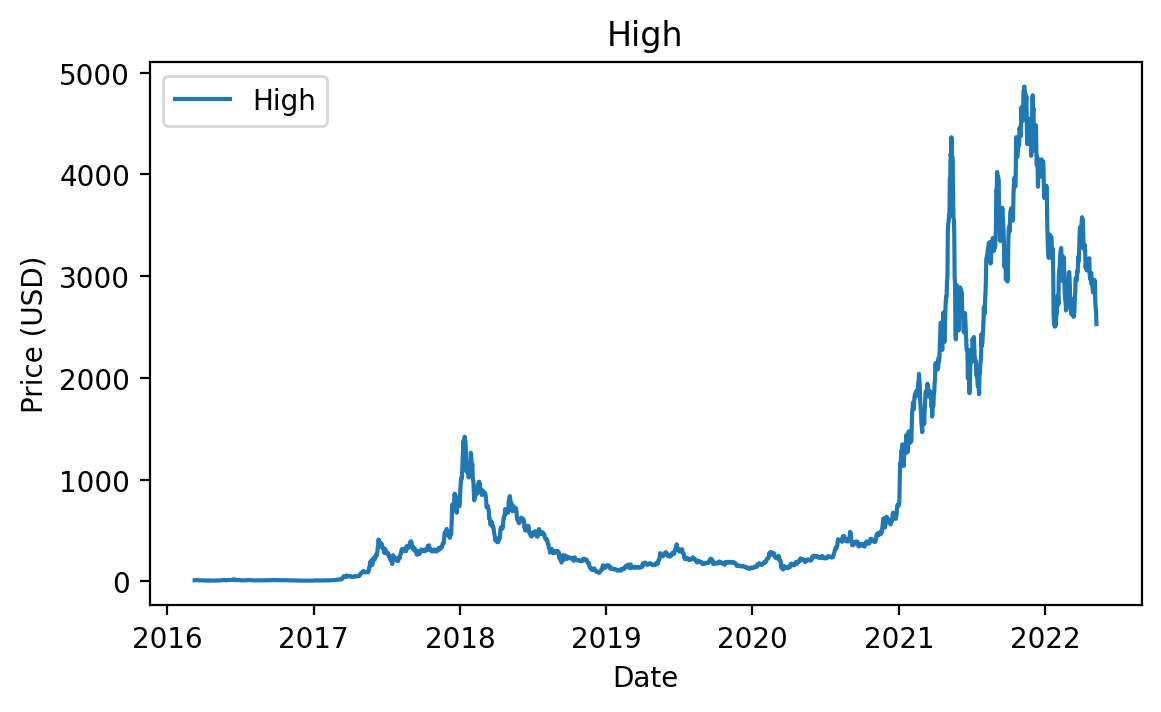

In [31]:
plt.figure(figsize=(6.40, 3.60), dpi=200)
plt.plot(ether_data["High"], label="High")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("High")
plt.show()

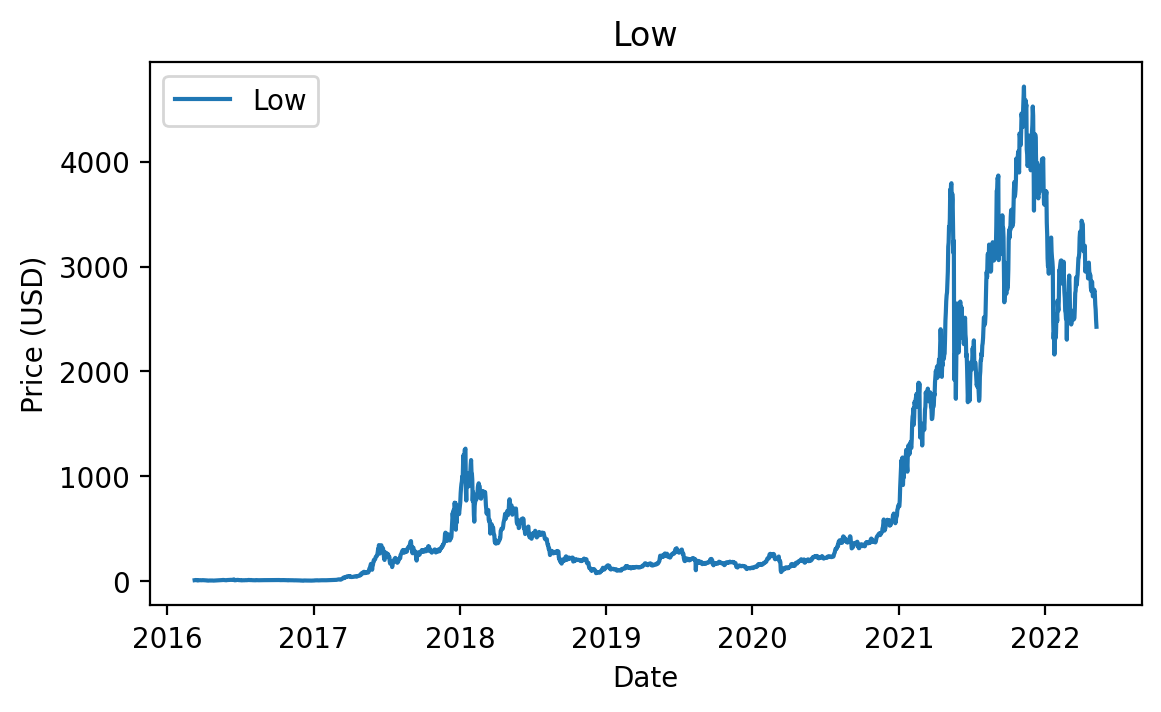

In [32]:
plt.figure(figsize=(6.40, 3.60), dpi=200)
plt.plot(ether_data["Low"], label="Low")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Low")
plt.show()

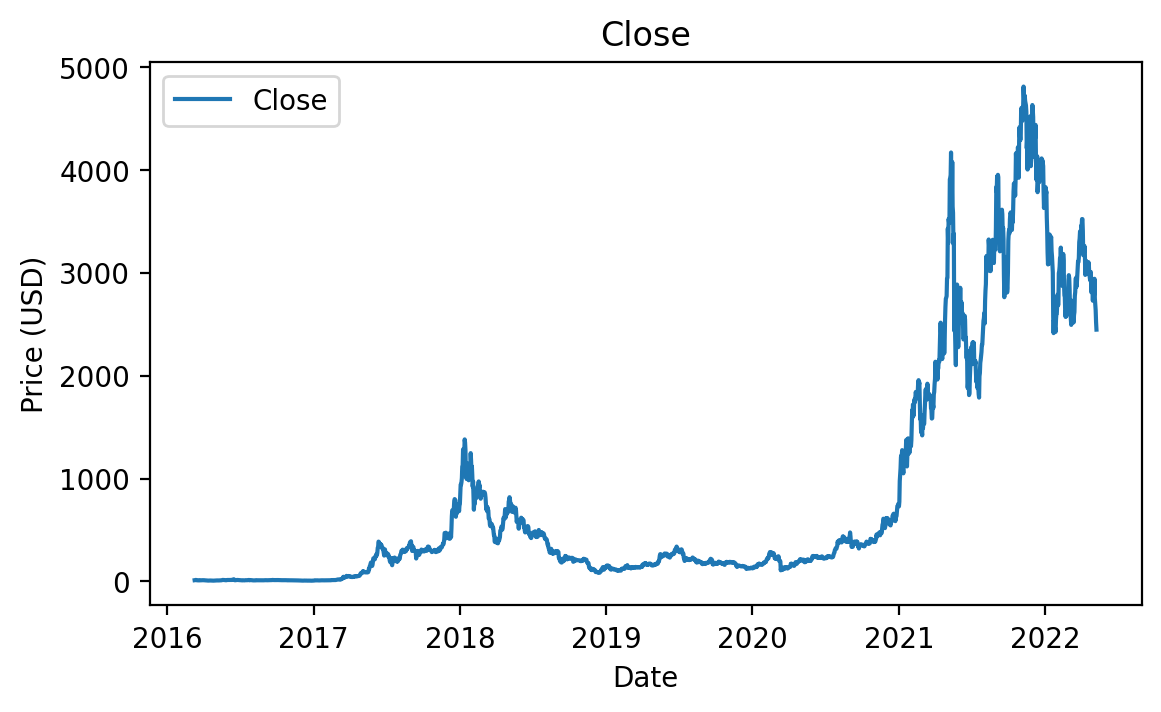

In [33]:
plt.figure(figsize=(6.40, 3.60), dpi=200)
plt.plot(ether_data["Close"], label="Close")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Close")
plt.show()

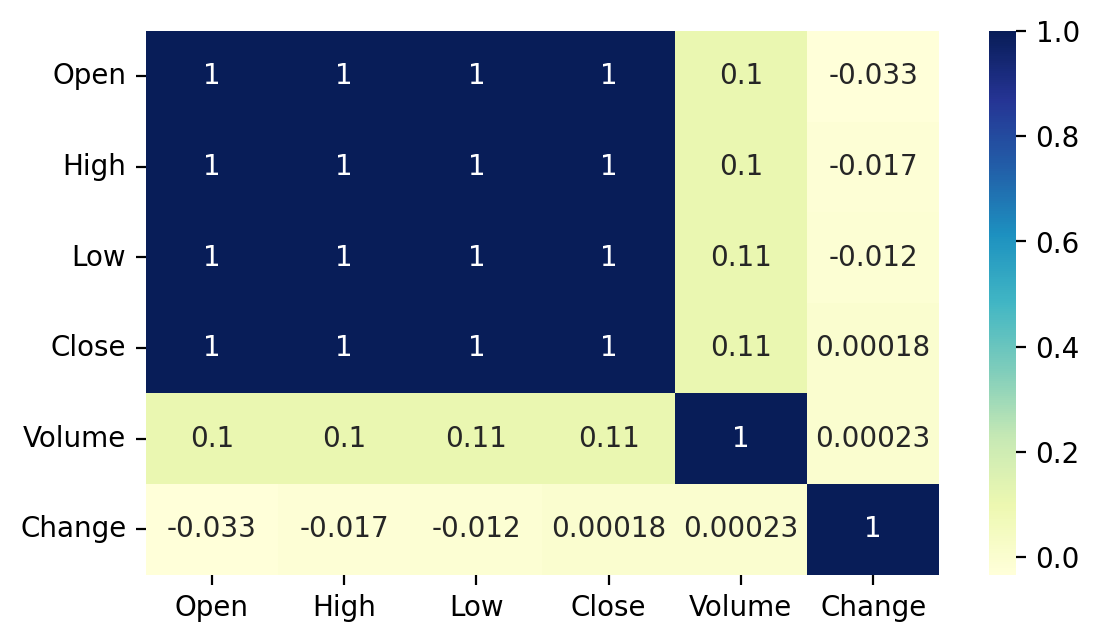

In [34]:
plt.figure(figsize=(6.40, 3.60), dpi=200)
sb.heatmap(ether_data.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [35]:
selected_features = ["Open", "High", "Close", "Low"]
lookback_period = 5
dates = list(ether_data.index)
ether_data_lstm = pd.DataFrame(ether_data, columns=selected_features)

In [36]:
ether_data_lstm

,Open,High,Close,Low
Date,,,,
2016-03-10,11.20,11.85,11.75,11.07
2016-03-11,11.75,11.95,11.95,11.75
2016-03-12,11.95,13.45,12.92,11.95
2016-03-13,12.92,15.07,15.07,12.92
2016-03-14,15.07,15.07,12.50,11.40
...,...,...,...,...
2022-05-05,2940.70,2952.84,2747.46,2730.95
2022-05-06,2747.60,2757.14,2692.88,2635.85
2022-05-07,2692.92,2703.11,2636.03,2589.29


In [37]:
ether_data_lstm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2252 entries, 2016-03-10 to 2022-05-09
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2252 non-null   float64
 1   High    2252 non-null   float64
 2   Close   2252 non-null   float64
 3   Low     2252 non-null   float64
dtypes: float64(4)
memory usage: 88.0 KB


c:\Users\samee\Projects\Thesis\venv-ether\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


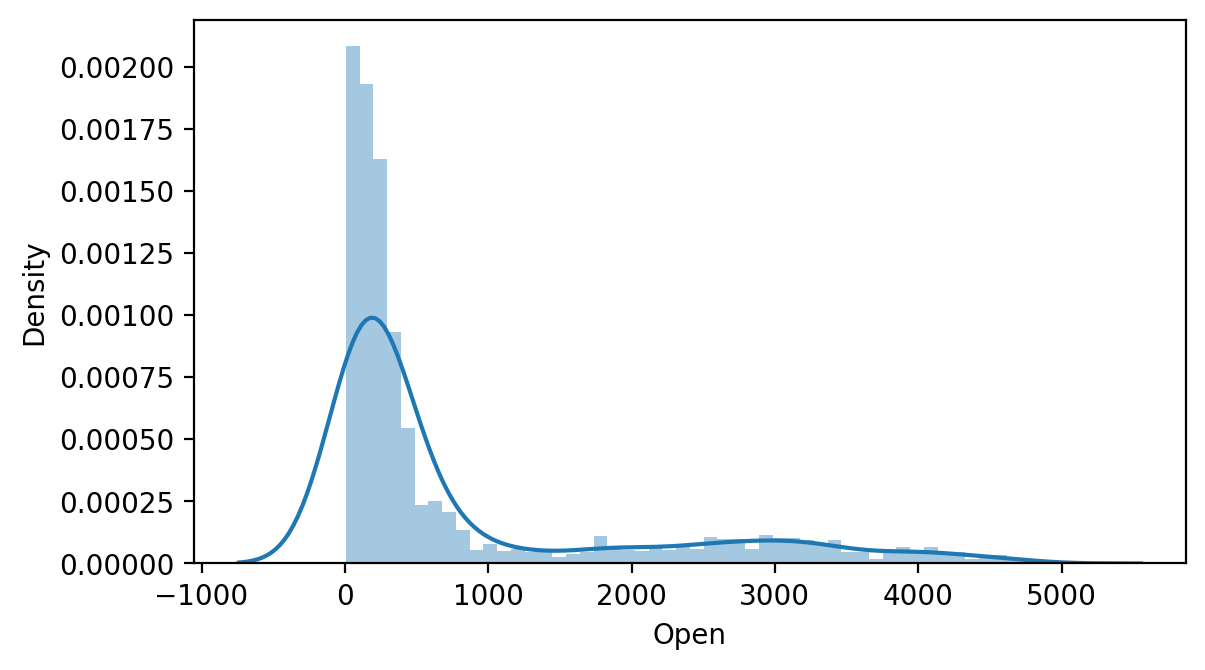

stat =  0.9999999999880529
p =  0.0
Not Gausssian.


In [38]:
plt.figure(figsize=(6.40, 3.60), dpi=200)
sb.distplot(ether_data["Open"])
plt.show()
test_normality(ether_data["Open"])

c:\Users\samee\Projects\Thesis\venv-ether\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


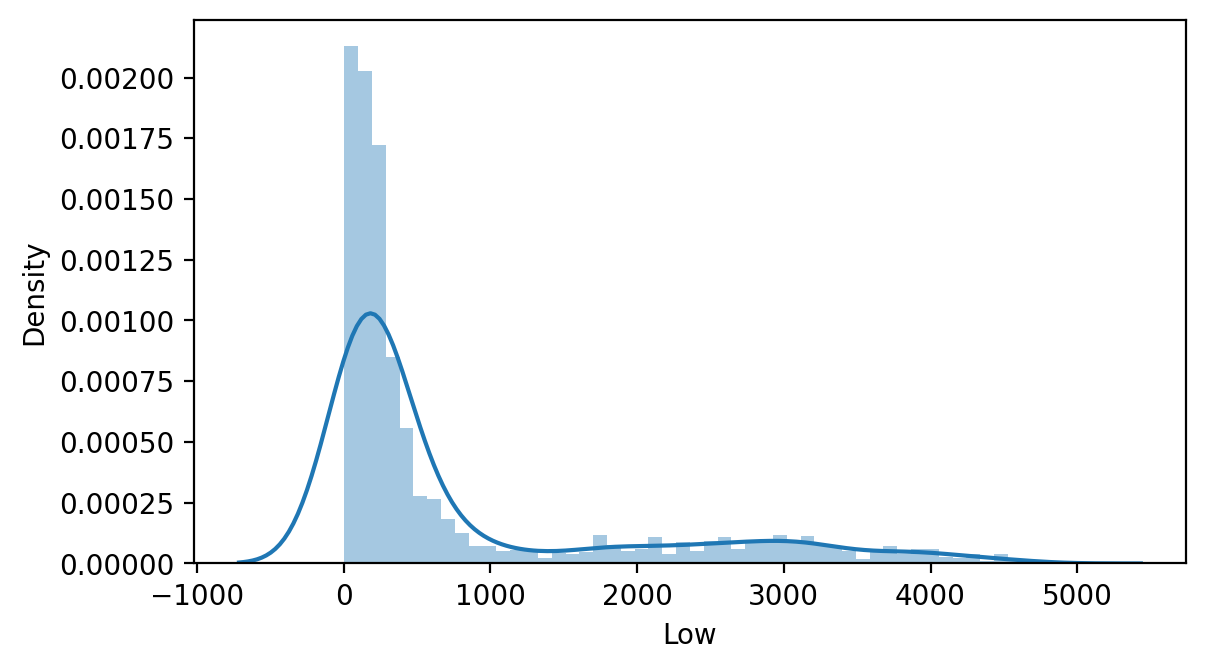

In [39]:
plt.figure(figsize=(6.40, 3.60), dpi=200)
sb.distplot(ether_data_lstm["Low"])
plt.show()

c:\Users\samee\Projects\Thesis\venv-ether\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


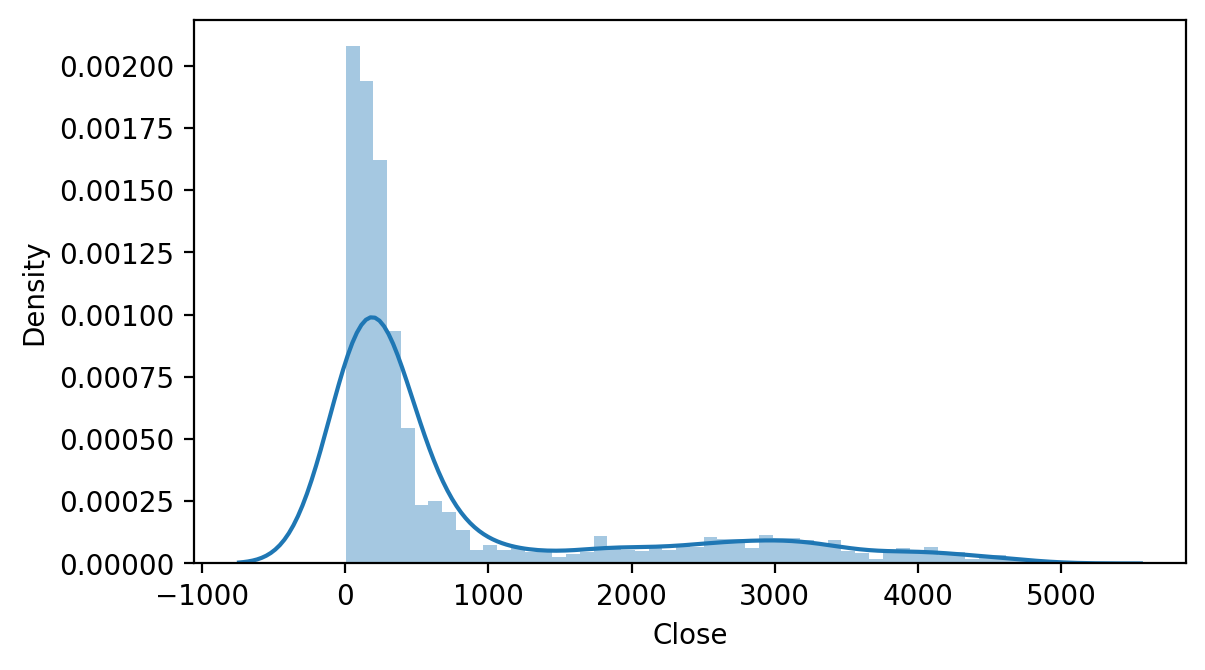

In [40]:
plt.figure(figsize=(6.40, 3.60), dpi=200)
sb.distplot(ether_data_lstm["Close"])
plt.show()

In [41]:
training_size = int(len(ether_data_lstm) * 0.80)
test_size = len(ether_data_lstm) - training_size
train_ether_data = ether_data_lstm[:training_size]
test_ether_data = ether_data_lstm[training_size:]

In [42]:
train_ether_data

,Open,High,Close,Low
Date,,,,
2016-03-10,11.20,11.85,11.75,11.07
2016-03-11,11.75,11.95,11.95,11.75
2016-03-12,11.95,13.45,12.92,11.95
2016-03-13,12.92,15.07,15.07,12.92
2016-03-14,15.07,15.07,12.50,11.40
...,...,...,...,...
2021-02-08,1612.98,1775.12,1750.18,1566.43
2021-02-09,1750.19,1818.94,1770.63,1711.40
2021-02-10,1770.81,1835.40,1742.09,1683.52


In [43]:
test_ether_data

,Open,High,Close,Low
Date,,,,
2021-02-13,1840.90,1871.36,1815.49,1766.05
2021-02-14,1815.44,1850.00,1801.78,1787.11
2021-02-15,1800.60,1835.51,1778.82,1661.09
2021-02-16,1778.63,1827.07,1781.69,1726.78
2021-02-17,1781.44,1854.03,1847.95,1734.15
...,...,...,...,...
2022-05-05,2940.70,2952.84,2747.46,2730.95
2022-05-06,2747.60,2757.14,2692.88,2635.85
2022-05-07,2692.92,2703.11,2636.03,2589.29


In [44]:
standard_scaler = StandardScaler()
scaled_train = standard_scaler.fit_transform(train_ether_data)
scaled_test = standard_scaler.fit_transform(test_ether_data)

In [45]:
scaled_train.shape

(1801, 4)

In [46]:
scaled_test.shape

(451, 4)

In [47]:
lstm_train_x, lstm_train_y = prepare_for_lstm(scaled_train, 5)
lstm_test_x, lstm_test_y = prepare_for_lstm(scaled_test, 5)

In [48]:
lstm_train_x.shape, lstm_train_y.shape

((1796, 5, 4), (1796, 4))

In [49]:
lstm_test_x.shape, lstm_test_y.shape

((446, 5, 4), (446, 4))

In [50]:
lstm_model = tf.keras.models.Sequential()
lstm_model.add(tf.keras.layers.LSTM(units=128, activation="linear", return_sequences=True, input_shape=(lstm_train_x.shape[1], lstm_train_x.shape[2])))
lstm_model.add(tf.keras.layers.Dropout(0.2))
lstm_model.add(tf.keras.layers.LSTM(units=64, input_shape=(lstm_train_x.shape[1], lstm_train_x.shape[2])))
lstm_model.add(tf.keras.layers.Dropout(0.2))
lstm_model.add(tf.keras.layers.Dense(units=lstm_train_x.shape[2]))
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 128)            68096     
                                                                 
 dropout (Dropout)           (None, 5, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 117,764
Trainable params: 117,764
Non-trainable params: 0
_________________________________________________________________


In [51]:
lstm_model.compile(optimizer="adam", loss="mean_squared_error")
training_result = lstm_model.fit(lstm_train_x, lstm_train_y, batch_size=64, epochs=100, verbose=1, shuffle=False, validation_data=(lstm_test_x, lstm_test_y), callbacks=None)

Epoch 1/100
29/29 [==============================] - 4s 31ms/step - loss: 0.4461 - val_loss: 0.1331
Epoch 2/100
29/29 [==============================] - 0s 10ms/step - loss: 0.2101 - val_loss: 0.1579
Epoch 3/100
29/29 [==============================] - 0s 10ms/step - loss: 0.1297 - val_loss: 0.1401
Epoch 4/100
29/29 [==============================] - 0s 10ms/step - loss: 0.1192 - val_loss: 0.1397
Epoch 5/100
29/29 [==============================] - 0s 10ms/step - loss: 0.1132 - val_loss: 0.1273
Epoch 6/100
29/29 [==============================] - 0s 10ms/step - loss: 0.0889 - val_loss: 0.1085
Epoch 7/100
29/29 [==============================] - 0s 10ms/step - loss: 0.0744 - val_loss: 0.0945
Epoch 8/100
29/29 [==============================] - 0s 10ms/step - loss: 0.0795 - val_loss: 0.0874
Epoch 9/100
29/29 [==============================] - 0s 11ms/step - loss: 0.0783 - val_loss: 0.0860
Epoch 10/100
29/29 [==============================] - 0s 9ms/step - loss: 0.0696 - val_loss: 0.0843


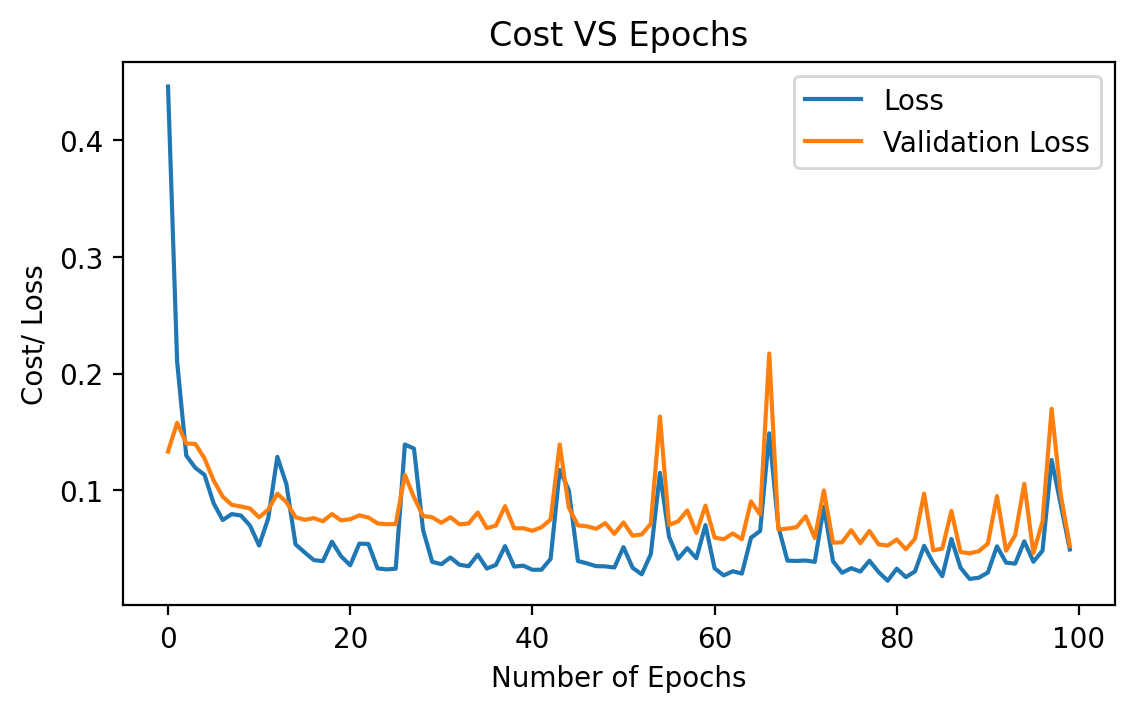

In [52]:
plt.figure(figsize=(6.40, 3.60), dpi=200)
plt.plot(training_result.history["loss"], label="Loss")
plt.plot(training_result.history["val_loss"], label="Validation Loss")
plt.legend()
plt.xlabel("Number of Epochs")
plt.ylabel("Cost/ Loss")
plt.title("Cost VS Epochs")
plt.show()

In [53]:
actual_ether_data = standard_scaler.inverse_transform(lstm_test_y)
predicted_ether_data = standard_scaler.inverse_transform(lstm_model.predict(lstm_test_x))

In [54]:
actual_ether_data.shape, predicted_ether_data.shape

((446, 4), (446, 4))

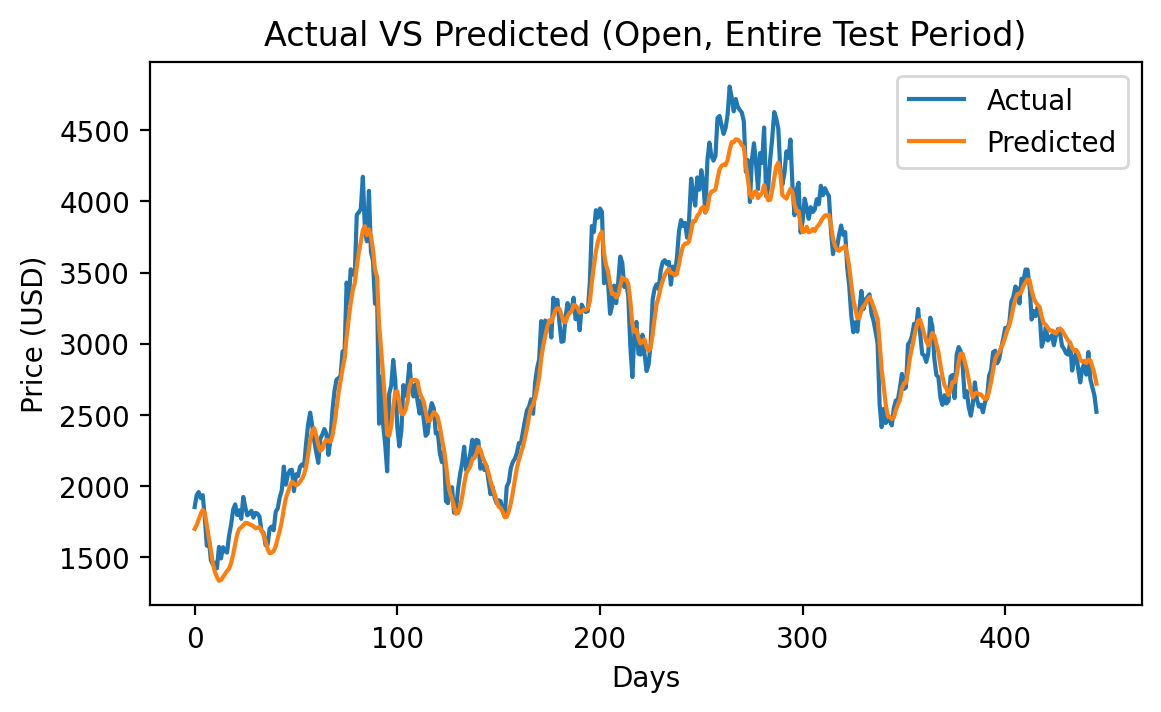

In [55]:
plt.figure(figsize=(6.40, 3.60), dpi=200)
plt.plot(actual_ether_data[:, 0], label="Actual")
plt.plot(predicted_ether_data[:, 0], label="Predicted")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.title("Actual VS Predicted (Open, Entire Test Period)")
plt.show()

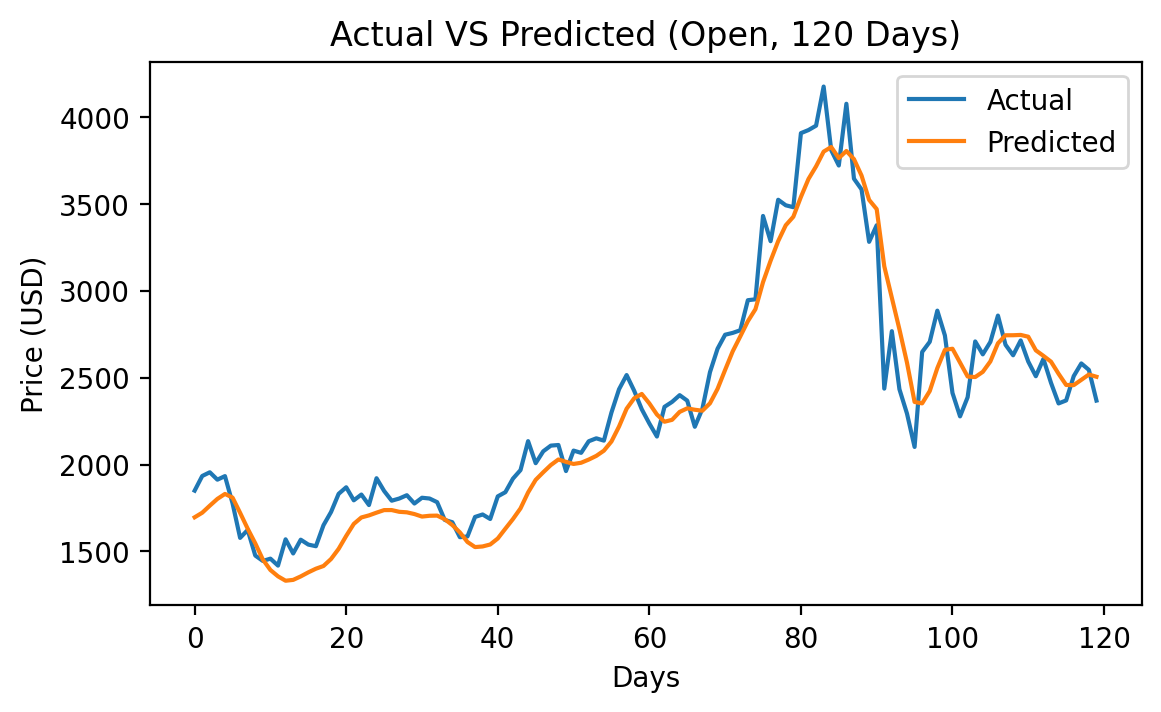

In [56]:
plt.figure(figsize=(6.40, 3.60), dpi=200)
plt.plot(actual_ether_data[:120, 0], label="Actual")
plt.plot(predicted_ether_data[:120, 0], label="Predicted")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.title("Actual VS Predicted (Open, 120 Days)")
plt.show()

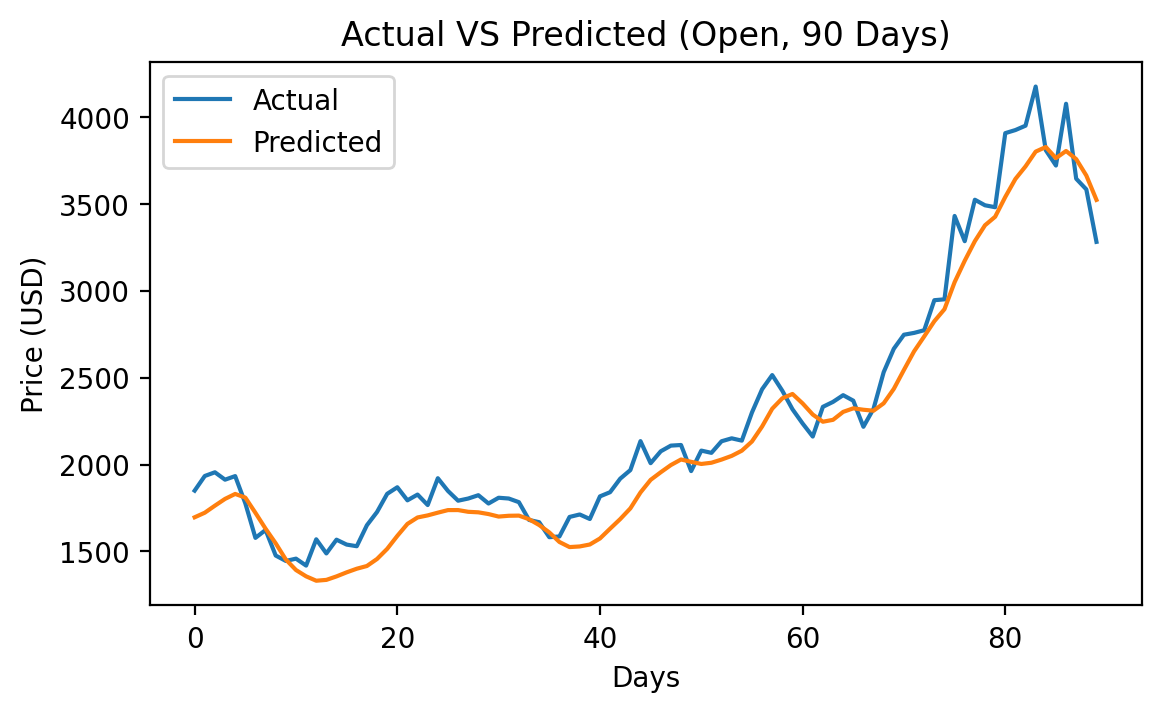

In [57]:
plt.figure(figsize=(6.40, 3.60), dpi=200)
plt.plot(actual_ether_data[:90, 0], label="Actual")
plt.plot(predicted_ether_data[:90, 0], label="Predicted")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.title("Actual VS Predicted (Open, 90 Days)")
plt.show()

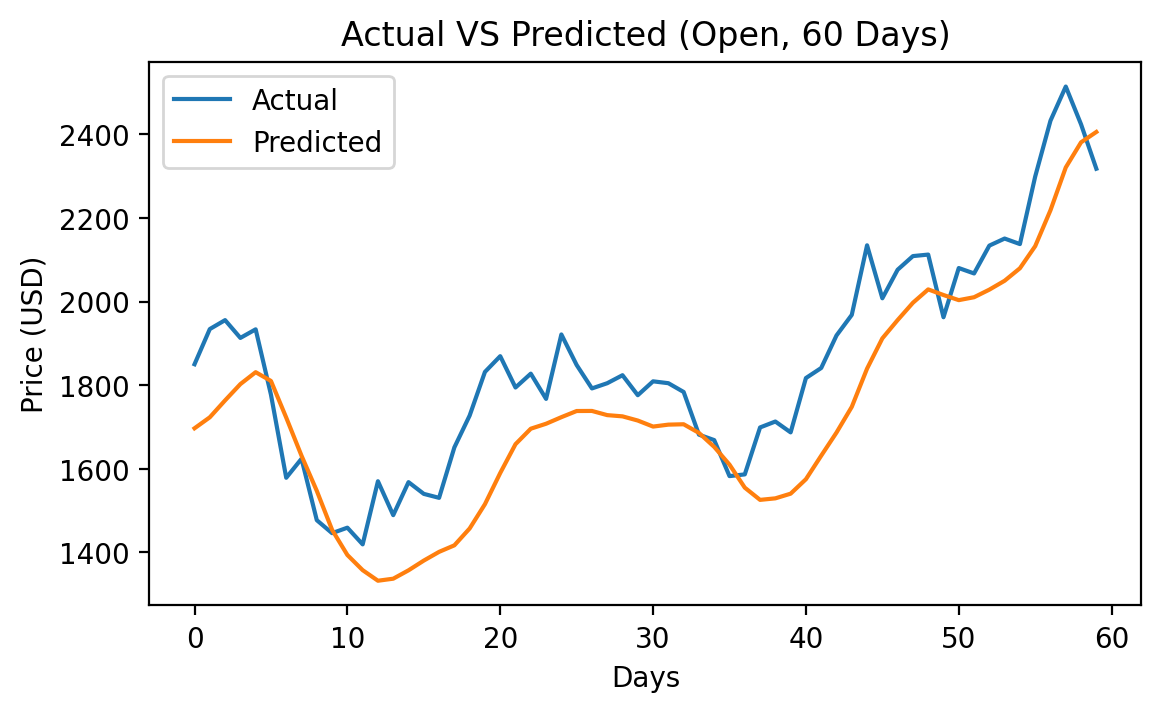

In [58]:
plt.figure(figsize=(6.40, 3.60), dpi=200)
plt.plot(actual_ether_data[:60, 0], label="Actual")
plt.plot(predicted_ether_data[:60, 0], label="Predicted")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.title("Actual VS Predicted (Open, 60 Days)")
plt.show()

In [85]:
print("Performance:")
mse = mean_squared_error(actual_ether_data[:, 0], predicted_ether_data[:, 0])
mse_scaled = mean_squared_error(lstm_test_y, lstm_model.predict(lstm_test_x))
print("mean squared error, scaled: ", mse_scaled)
rmse = math.sqrt(mse)
mae = mean_absolute_error(actual_ether_data[:, 0], predicted_ether_data[:, 0])
mape = mean_absolute_percentage_error(actual_ether_data[:, 0], predicted_ether_data[:, 0]) * 100
print("mean squared error: ", mse)
print("root mean square error: ", rmse)
print("mean absolute error: ", mae)
print("mean absolute percentage error: ", mape, "%")

Performance:
mean squared error, scaled:  0.05220303635158838
mean squared error:  26939.170989078826
root mean square error:  164.13156609585747
mean absolute error:  130.7308929087549
mean absolute percentage error:  4.554560591868249 %
